In [102]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Model imports
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

In [105]:
# CSV for reported Lyme Disease cases reported to CDC CDC.gov
# https://www.cdc.gov/lyme/stats/survfaq.html
df = pd.read_csv('/Users/tcbon/Downloads/LD-Case-Counts-by-County-00-17.csv', encoding='latin-1')

In [106]:
df.head()

,Ctyname,Stname,STCODE,CTYCODE,Cases2000,Cases2001,Cases2002,Cases2003,Cases2004,Cases2005,...,Cases2008,Cases2009,Cases2010,Cases2011,Cases2012,Cases2013,Cases2014,Cases2015,Cases2016,Cases2017
0,Autauga County,Alabama,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
1,Baldwin County,Alabama,1,3,1,0,1,0,0,0,...,0,1,0,1,1,0,3,1,2,2
2,Barbour County,Alabama,1,5,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,Bibb County,Alabama,1,7,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,Blount County,Alabama,1,9,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [4]:
# # Adding County identifier column
# df['county_id'] = df['STCODE'].apply(str) + '-' + df['CTYCODE'].apply(str)

In [19]:
# # Removing excess identifier columns
# df = df.drop(columns=['STCODE','CTYCODE'])

In [107]:
# Removing 2000- 2009 columns
df = df.drop(columns=['Cases2000','Cases2001','Cases2002','Cases2003',
                 'Cases2004','Cases2005','Cases2006','Cases2007',
                 'Cases2008','Cases2009'])

In [108]:
df.head()

,Ctyname,Stname,STCODE,CTYCODE,Cases2010,Cases2011,Cases2012,Cases2013,Cases2014,Cases2015,Cases2016,Cases2017
0,Autauga County,Alabama,1,1,0,0,0,0,0,0,2,0
1,Baldwin County,Alabama,1,3,0,1,1,0,3,1,2,2
2,Barbour County,Alabama,1,5,0,1,0,0,0,0,0,0
3,Bibb County,Alabama,1,7,0,0,0,0,1,0,0,0
4,Blount County,Alabama,1,9,0,1,0,0,0,0,0,0


([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text xticklabel objects>)

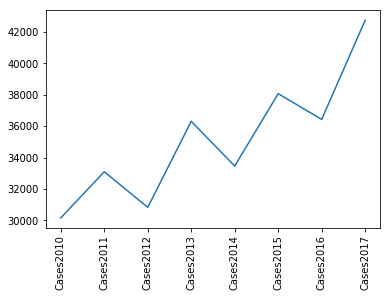

In [139]:
plt.plot(df.iloc[:, 4:].sum())
plt.xticks(rotation='vertical')

In [109]:
# CSV for county population data from 2010 - 2017 (census.gov)
# https://www.census.gov/data/datasets/2017/demo/popest/counties-total.html
# Dictionary -> https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2017/co-est2017-alldata.pdf
pop_df = pd.read_csv('/Users/tcbon/Downloads/co-est2017-alldata.csv', encoding='latin-1')

In [110]:
pop_df = pop_df.iloc[:,5:17]

In [111]:
pop_df = pop_df.drop(columns=['CENSUS2010POP','ESTIMATESBASE2010'])

In [112]:
pop_df.head()

,STNAME,CTYNAME,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017
0,Alabama,Alabama,4785579,4798649,4813946,4827660,4840037,4850858,4860545,4874747
1,Alabama,Autauga County,54750,55199,54927,54695,54864,54838,55278,55504
2,Alabama,Baldwin County,183110,186534,190048,194736,199064,202863,207509,212628
3,Alabama,Barbour County,27332,27351,27175,26947,26749,26264,25774,25270
4,Alabama,Bibb County,22872,22745,22658,22503,22533,22561,22633,22668


In [113]:
# Threshold for "high incidence"
10/100000

0.0001

In [255]:
all_years_with_pop = df.merge(pop_df, left_on=['Stname','Ctyname'],right_on=['STNAME','CTYNAME'])

In [242]:
# Identifying counties with high incidence in 2017
# all_years_with_pop[(all_years_with_pop.Cases2017 / all_years_with_pop.POPESTIMATE2017) > 0.0001]

In [256]:
#  Creating new columns for yearly incidence rate(number of cases/total population)
for i in range(8):
    all_years_with_pop['201{}_incid_rate'.format(i)] = (all_years_with_pop['Cases201{}'.format(i)] / all_years_with_pop['POPESTIMATE201{}'.format(i)])

In [257]:
all_years_with_pop.columns

Index(['Ctyname', 'Stname', 'STCODE', 'CTYCODE', 'Cases2010', 'Cases2011',
       'Cases2012', 'Cases2013', 'Cases2014', 'Cases2015', 'Cases2016',
       'Cases2017', 'STNAME', 'CTYNAME', 'POPESTIMATE2010', 'POPESTIMATE2011',
       'POPESTIMATE2012', 'POPESTIMATE2013', 'POPESTIMATE2014',
       'POPESTIMATE2015', 'POPESTIMATE2016', 'POPESTIMATE2017',
       '2010_incid_rate', '2011_incid_rate', '2012_incid_rate',
       '2013_incid_rate', '2014_incid_rate', '2015_incid_rate',
       '2016_incid_rate', '2017_incid_rate'],
      dtype='object')

In [258]:
all_years_with_pop = all_years_with_pop.loc[:, ['STCODE', 'CTYCODE','STNAME', 'CTYNAME', '2010_incid_rate', 
                        '2011_incid_rate', '2012_incid_rate', '2013_incid_rate',
                        '2014_incid_rate', '2015_incid_rate','2016_incid_rate', 
                        '2017_incid_rate']]

In [259]:
# all_years_with_pop.CTYNAME = all_years_with_pop.CTYNAME.str.strip(' County')

In [260]:
all_years_with_pop

,STCODE,CTYCODE,STNAME,CTYNAME,2010_incid_rate,2011_incid_rate,2012_incid_rate,2013_incid_rate,2014_incid_rate,2015_incid_rate,2016_incid_rate,2017_incid_rate
0,1,1,Alabama,Autauga County,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,3.618076e-05,0.000000e+00
1,1,3,Alabama,Baldwin County,0.000000,0.000005,5.261829e-06,0.000000,1.507053e-05,0.000005,9.638136e-06,9.406099e-06
2,1,5,Alabama,Barbour County,0.000000,0.000037,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
3,1,7,Alabama,Bibb County,0.000000,0.000000,0.000000e+00,0.000000,4.437935e-05,0.000000,0.000000e+00,0.000000e+00
4,1,9,Alabama,Blount County,0.000000,0.000017,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
5,1,11,Alabama,Bullock County,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,9.700262e-05
6,1,13,Alabama,Butler County,0.000000,0.000048,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
7,1,15,Alabama,Calhoun County,0.000000,0.000017,8.531040e-06,0.000026,1.725015e-05,0.000000,8.697165e-06,0.000000e+00
8,1,17,Alabama,Chambers County,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000029,0.000000e+00,0.000000e+00
9,1,19,Alabama,Cherokee County,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00


In [128]:
all_years_with_pop[all_years_with_pop.STNAME == 'District of Columbia']

,STCODE,CTYCODE,STNAME,CTYNAME,2010_incid_rate,2011_incid_rate,2012_incid_rate,2013_incid_rate,2014_incid_rate,2015_incid_rate,2016_incid_rate,2017_incid_rate
327,11,1,District of Columbia,District of Columbia,0.000069,0.0,0.0,0.000054,0.000061,0.00018,0.000151,0.000121
328,11,1,District of Columbia,District of Columbia,0.000069,0.0,0.0,0.000054,0.000061,0.00018,0.000151,0.000121


In [129]:
# CSV for urban vs rural by county
# Dictionary _> https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/2010-urban-lists-record-layout.html
urban_df = pd.read_excel('/Users/tcbon/Downloads/PctUrbanRural_County.xls')

In [130]:
urban_df.head()

,STATE,COUNTY,STATENAME,COUNTYNAME,POP_COU,AREA_COU,POP_URBAN,POPPCT_URBAN,AREA_URBAN,AREAPCT_URBAN,...,POP_UC,POPPCT_UC,AREA_UC,AREAPCT_UC,POPDEN_UC,POP_RURAL,POPPCT_RURAL,AREA_RURAL,AREAPCT_RURAL,POPDEN_RURAL
0,1,1,Alabama,Autauga,54571,1539582278,31650,58.00,50882539,3.30,...,0,0.00,0,0.00,NaN,22921,42.00,1488699739,96.70,39.9
1,1,3,Alabama,Baldwin,182265,4117521611,105205,57.72,275001368,6.68,...,41556,22.80,111381848,2.71,966.3,77060,42.28,3842520243,93.32,51.9
2,1,5,Alabama,Barbour,27457,2291818968,8844,32.21,17447656,0.76,...,8844,32.21,17447656,0.76,1312.8,18613,67.79,2274371312,99.24,21.2
3,1,7,Alabama,Bibb,22915,1612480789,7252,31.65,18903236,1.17,...,7252,31.65,18903236,1.17,993.6,15663,68.35,1593577553,98.83,25.5
4,1,9,Alabama,Blount,57322,1669961855,5760,10.05,10874700,0.65,...,5374,9.38,9851721,0.59,1412.8,51562,89.95,1659087155,99.35,80.5


([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text xticklabel objects>)

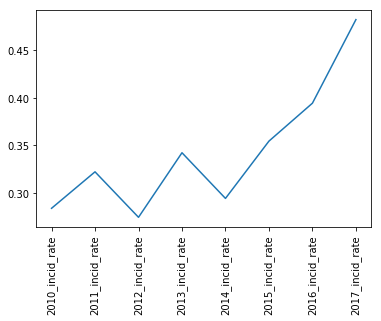

In [138]:
plt.plot(all_years_with_pop.iloc[:, 4:].sum())
plt.xticks(rotation='vertical')

In [142]:
# important factors
# mild winter, high acorn prodcution yerar before which leads to high mice population which are tick hosts

In [177]:
# all_years_with_pop = all_years_with_pop.rename(columns={'2010_incid_rate':'A-2010_incid_rate','2011_incid_rate':'A-2011_incid_rate', '2012_incid_rate':'A-2012_incid_rate', '2013_incid_rate':'A-2013_incid_rate','2014_incid_rate':'A-2014_incid_rate', '2015_incid_rate':'A-2015_incid_rate', '2016_incid_rate':'A-2016_incid_rate','2017_incid_rate':'A-2017_incid_rate'})


In [265]:
all_years_with_pop

,STNAME,CTYNAME,year,incidence_rate
0,Alabama,Autauga County,2010,0.000000e+00
1,Alabama,Baldwin County,2010,0.000000e+00
2,Alabama,Barbour County,2010,0.000000e+00
3,Alabama,Bibb County,2010,0.000000e+00
4,Alabama,Blount County,2010,0.000000e+00
5,Alabama,Bullock County,2010,0.000000e+00
6,Alabama,Butler County,2010,0.000000e+00
7,Alabama,Calhoun County,2010,0.000000e+00
8,Alabama,Chambers County,2010,0.000000e+00
9,Alabama,Cherokee County,2010,0.000000e+00


Preparing data for merging

In [262]:
# all_years_with_pop
all_years_with_pop = pd.melt(all_years_with_pop,id_vars=['STNAME','CTYNAME'],value_vars=['2010_incid_rate','2011_incid_rate', '2012_incid_rate', 
                                                    '2013_incid_rate','2014_incid_rate', '2015_incid_rate', 
                                                    '2016_incid_rate','2017_incid_rate'],var_name='year',value_name='incidence_rate')



In [263]:
years= [x for x in range(8)]
for year in years:
    all_years_with_pop.year[all_years_with_pop.year == '201{}_incid_rate'.format(year)] = 2010 + year

/Users/tcbon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [264]:
all_years_with_pop.year.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], dtype=object)

In [266]:
with open('target_variable.pickle','wb') as f:
    pickle.dump(all_years_with_pop,f)